# Multilingual Search with Cohere and Langchain

***Read the accompanying [blog post here](https://txt.cohere.ai/search-cohere-langchain/).***

This notebook contains two examples for performing multilingual search using Cohere and Langchain. Langchain is a library that assists the development of applications built on top of large language models (LLMs), such as Cohere's models.

In short, Cohere makes it easy for developers to leverage LLMs and Langchain makes it easy to build applications with these models.

We'll go through the following examples:
- **Example 1 - Basic Multilingual Search**

  This is a simple example of multilingual search over a list of documents.

  The steps in summary:
  - Import a list of documents
  - Embed the documents and store them in an index
  - Enter a query
  - Return the document most similar to the query
- **Example 2 - Search-Based Question Answering**

  This example shows a more involved example where search is combined with text generation to answer questions about long-form documents.

  The steps in summary:
  - Add an article and chunk it into smaller passages
  - Embed the passages and store them in an index
  - Enter a question
  - Answer the question based on the most relevant documents

In [3]:
! pip install cohere langchain qdrant-client tfds-nightly> /dev/null

In [4]:
from langchain.embeddings.cohere import CohereEmbeddings
from langchain.llms import Cohere
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.chains import RetrievalQA
from langchain.vectorstores import Qdrant
from langchain.document_loaders import TextLoader
import os
import random
import textwrap as tr

In [5]:
os.environ["COHERE_API_KEY"] = "COHERE_API_KEY" # add your Cohere API key here


# Example 1 - Basic Multilingual Search

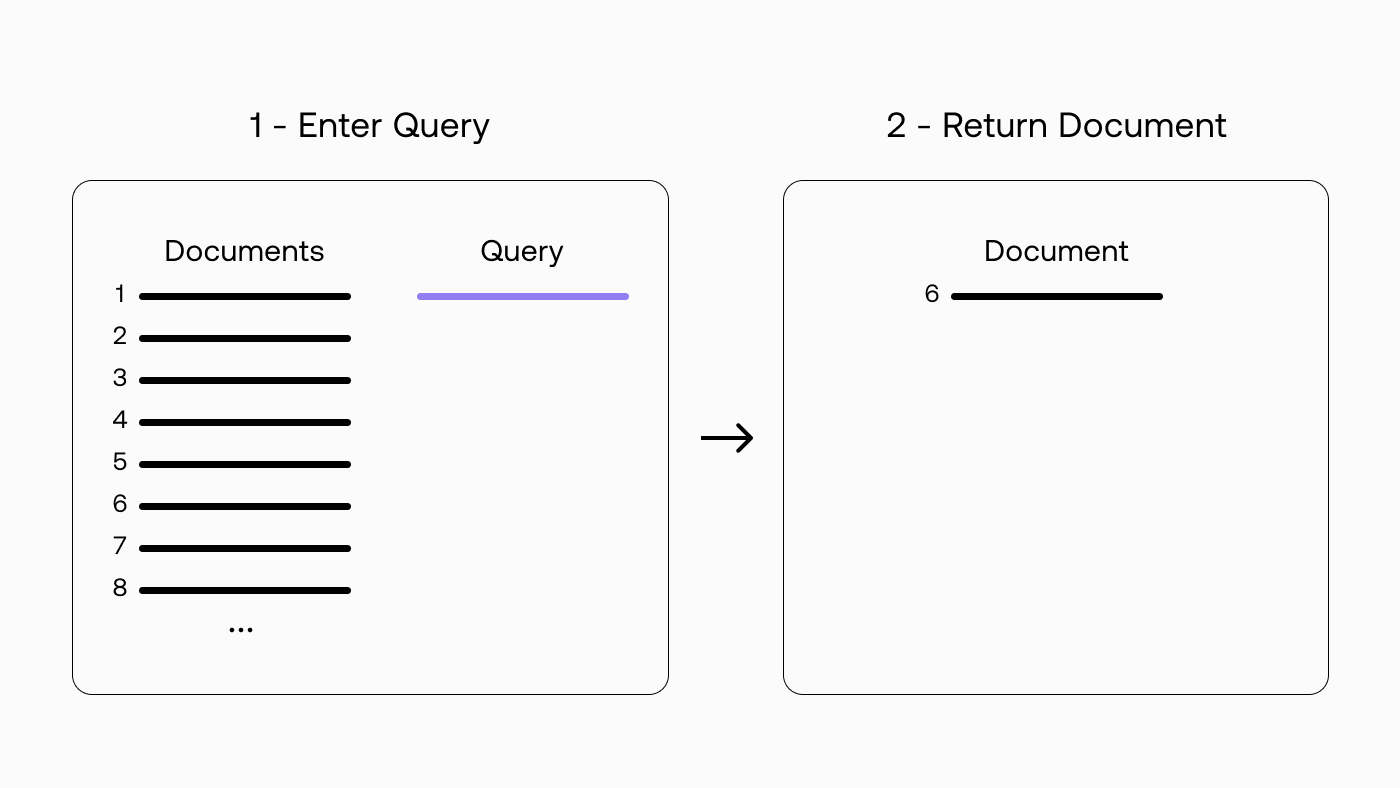

### Import a list of documents

In [6]:
# Import documents
import tensorflow_datasets as tfds
dataset = tfds.load('trec', split='train')
texts = [item['text'].decode('utf-8') for item in tfds.as_numpy(dataset)]
print(f"Number of documents: {len(texts)}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5452 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/trec/1.0.0.incomplete29FWSU/trec-train.tfrecord*...:   0%|          | 0/54…

Generating test examples...:   0%|          | 0/500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/trec/1.0.0.incomplete29FWSU/trec-test.tfrecord*...:   0%|          | 0/500…

Dataset trec downloaded and prepared to /root/tensorflow_datasets/trec/1.0.0. Subsequent calls will reuse this data.
Number of documents: 5452


In [7]:
# Print a few sample documents
random.seed(11)
for item in random.sample(texts, 5):
  print(item) 

What is the starting salary for beginning lawyers ?
Where did Bill Gates go to college ?
What task does the Bouvier breed of dog perform ?
What are the top boy names in the U.S. ?
What is a female rabbit called ?


### Embed the documents and store them in an index

In [8]:
# Define the embeddings model
embeddings = CohereEmbeddings(model = "multilingual-22-12")

# Embed the documents and store in index
db = Qdrant.from_texts(texts, embeddings, location=":memory:", collection_name="my_documents", distance_func="Dot")

### Enter a query

In [9]:
queries = ["How to get in touch with Bill Gates",
           "Comment entrer en contact avec Bill Gates",
           "Cara menghubungi Bill Gates"]

queries_lang = ["English", "French", "Indonesian"] 

### Return the document most similar to the query

In [10]:
# Return document most similar to the query
answers = []
for query in queries:
  docs = db.similarity_search(query)
  answers.append(docs[0].page_content)

In [11]:
# Print the top document match for each query
for idx,query in enumerate(queries):
  print(f"Query language: {queries_lang[idx]}")
  print(f"Query: {query}")
  print(f"Most similar existing question: {answers[idx]}")
  print("-"*20,"\n")

Query language: English
Query: How to get in touch with Bill Gates
Most similar existing question: What is Bill Gates of Microsoft E-mail address ?
-------------------- 

Query language: French
Query: Comment entrer en contact avec Bill Gates
Most similar existing question: What is Bill Gates of Microsoft E-mail address ?
-------------------- 

Query language: Indonesian
Query: Cara menghubungi Bill Gates
Most similar existing question: What is Bill Gates of Microsoft E-mail address ?
-------------------- 



# Example 2 - Search-Based Question Answering

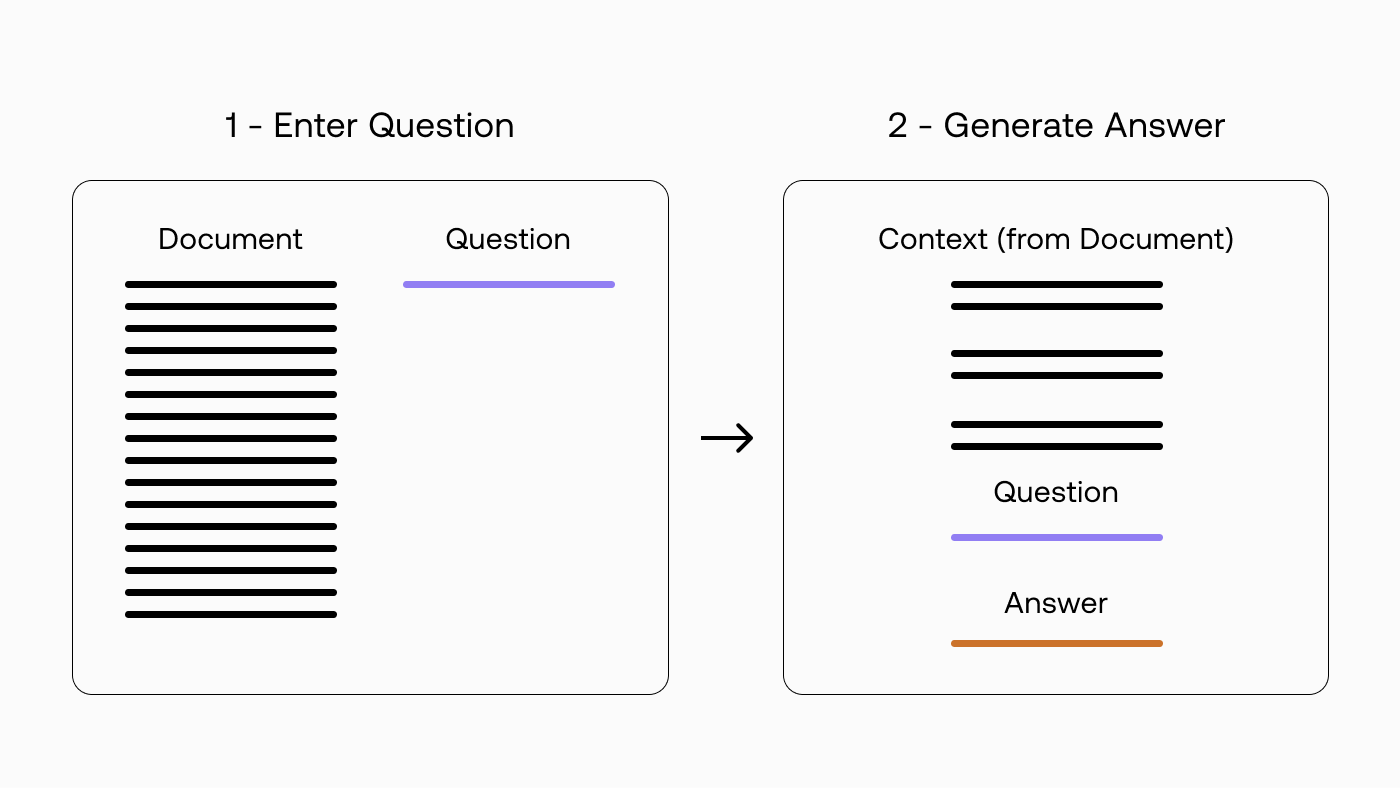

## Add an article and chunk it into smaller passages

In [12]:
# We'll use Steve Jobs' Stanford University commencement address as the example. Link: https://news.stanford.edu/2005/06/12/youve-got-find-love-jobs-says/

!wget 'https://docs.google.com/uc?export=download&id=1f1INWOfJrHTFmbyF_0be5b4u_moz3a4F' -O steve-jobs-commencement.txt

--2023-06-06 13:32:47--  https://docs.google.com/uc?export=download&id=1f1INWOfJrHTFmbyF_0be5b4u_moz3a4F
Resolving docs.google.com (docs.google.com)... 74.125.20.101, 74.125.20.139, 74.125.20.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/grnqu4me0kflumfvifh49n4290l9cjqt/1686058350000/12721472133292131824/*/1f1INWOfJrHTFmbyF_0be5b4u_moz3a4F?e=download&uuid=e2ac9192-abca-449b-8de8-3437f5b82275 [following]
--2023-06-06 13:32:47--  https://doc-0g-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/grnqu4me0kflumfvifh49n4290l9cjqt/1686058350000/12721472133292131824/*/1f1INWOfJrHTFmbyF_0be5b4u_moz3a4F?e=download&uuid=e2ac9192-abca-449b-8de8-3437f5b82275
Resolving doc-0g-84-docs.googleusercontent.com (doc-0g-84-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:

In [13]:
loader = TextLoader("steve-jobs-commencement.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

## Embed the passages and store them in an index

In [14]:
embeddings = CohereEmbeddings(model = "multilingual-22-12")
db = Qdrant.from_documents(texts, embeddings, location=":memory:", collection_name="my_documents", distance_func="Dot")

## Enter a question

In [15]:
questions = [
           "What did the author liken The Whole Earth Catalog to?",
           "What was Reed College great at?",
           "What was the author diagnosed with?",
           "What is the key lesson from this article?",
           "What did the article say about Michael Jackson?",
           ]

## Answer the question based on the most relevant documents


In [16]:
# Create our own prompt template

prompt_template = """Text: {context}

Question: {question}

Answer the question based on the text provided. If the text doesn't contain the answer, reply that the answer is not available."""

PROMPT = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)

In [24]:
chain_type_kwargs = {"prompt": PROMPT}

qa = RetrievalQA.from_chain_type(llm=Cohere(model="command-nightly", temperature=0), 
                                 chain_type="stuff", 
                                 retriever=db.as_retriever(), 
                                 chain_type_kwargs=chain_type_kwargs, 
                                 return_source_documents=True)

for question in questions:
  answer = qa({"query": question})
  result = answer["result"].replace("\n","").replace("Answer:","")
  sources = answer['source_documents']
  print("-"*150,"\n")
  print(f"Question: {question}")
  print(f"Answer: {result}")

  ### COMMENT OUT THE 4 LINES BELOW TO HIDE THE SOURCES
  print(f"\nSources:")
  for idx, source in enumerate(sources):
    source_wrapped = tr.fill(str(source.page_content), width=150)
    print(f"{idx+1}: {source_wrapped}")

------------------------------------------------------------------------------------------------------------------------------------------------------ 

Question: What did the author liken The Whole Earth Catalog to?
Answer: It was sort of like Google in paperback form, 35 years before Google came along

Sources:
1: When I was young, there was an amazing publication called The Whole Earth Catalog, which was one of the bibles of my generation. It was created by a
fellow named Stewart Brand not far from here in Menlo Park, and he brought it to life with his poetic touch. This was in the late 1960s, before
personal computers and desktop publishing, so it was all made with typewriters, scissors and Polaroid cameras. It was sort of like Google in paperback
form, 35 years before Google came along: It was
2: Stewart and his team put out several issues of The Whole Earth Catalog, and then when it had run its course, they put out a final issue. It was the
mid-1970s, and I was your age. On the b

## Questions in French

In [25]:
questions_fr = [
           "À quoi se compare The Whole Earth Catalog ?",
           "Dans quoi Reed College était-il excellent ?",
           "De quoi l'auteur a-t-il été diagnostiqué ?",
           "Quelle est la leçon clé de cet article ?",
           "Que disait l'article sur Michael Jackson ?",
           ]

In [26]:
# import langchain
# langchain.debug = False

In [27]:
# Generate the answer given the context

chain_type_kwargs = {"prompt": PROMPT}

qa = RetrievalQA.from_chain_type(llm=Cohere(model="command-nightly", temperature=0), 
                                 chain_type="stuff", 
                                 retriever=db.as_retriever(), 
                                 chain_type_kwargs=chain_type_kwargs, 
                                 return_source_documents=True)

for question in questions_fr:
  answer = qa({"query": question})
  result = answer["result"].replace("\n","").replace("Answer:","")
  sources = answer['source_documents']
  print("-"*20,"\n")
  print(f"Question: {question}")
  print(f"Answer: {result}")

-------------------- 

Question: À quoi se compare The Whole Earth Catalog ?
Answer: The Whole Earth Catalog was like Google in paperback form, 35 years before Google came along.
-------------------- 

Question: Dans quoi Reed College était-il excellent ?
Answer: Reed College offered the best calligraphy instruction in the country.
-------------------- 

Question: De quoi l'auteur a-t-il été diagnostiqué ?
Answer: The author was diagnosed with a very rare form of pancreatic cancer that is curable with surgery.
-------------------- 

Question: Quelle est la leçon clé de cet article ?
Answer: The key lesson of this article is that remembering that you will die soon is the most important tool to help one make the big choices in life.
-------------------- 

Question: Que disait l'article sur Michael Jackson ?
Answer: The text does not contain the answer to the question.
